In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
figure_params.set_rc_params()
import os
import matplotlib.pyplot as plt
import pyaldata as pyal
import seaborn as sns
import pickle
import pandas as pd
from tools.test import test_model
from tqdm.auto import tqdm
from textwrap import wrap
from scipy.linalg import orth, null_space
from sklearn.linear_model import LinearRegression
import numpy as np
import math

from matplotlib import cm
import figure_params

figure_params.set_rc_params()
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'fig2/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

#run simulations for figure, will take a while to run
import subprocess
os.chdir(Constants.PROJ_DIR)
subprocess.run(["bash", "simulation/fig_simulations/fig2_sims.sh"]) #uncomment code to make datasets if not made yet


<module 'tools.dataTools' from '/home/jcc319/structure_proj/tools/dataTools.py'>

In [2]:
seeds = Constants.SEEDS
repertoires  = Constants.UNIS
reps = repertoires
smooth = True
ci = 95


#### Model output after skill learning

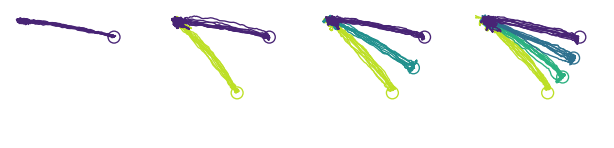

In [3]:
axs, params = dt.graph_outputs_all(Constants.SEED_EX, 'uni_rad', reps)
plt.savefig(SUBFIG_DIR + "output_" + params +'.pdf', format='pdf')

#### Loss during skill learning

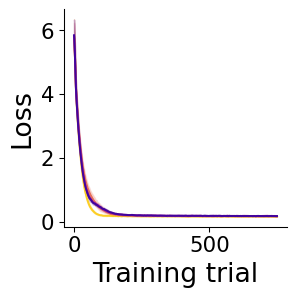

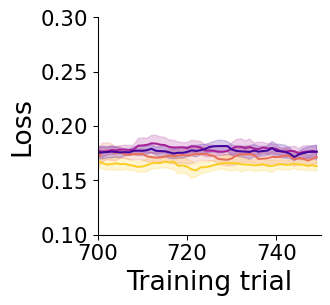

In [4]:
fig, ax = plt.subplots(ncols = 1, figsize = (3,3))
g, params = dt.graph_loss(seeds, 'uni_rad', reps, smooth=smooth, rel_loss = False)

plt.savefig(SUBFIG_DIR + "loss_"+params+".pdf", format='pdf', bbox_inches='tight' )
fig, ax = plt.subplots(ncols = 1, figsize = (3,3))
g, params = dt.graph_loss(seeds, 'uni_rad', reps, smooth=smooth, rel_loss = False, xlim=[700,750])
g.set_ylim([0.1,0.3])

plt.savefig(SUBFIG_DIR + "loss_"+params+".pdf", format='pdf', bbox_inches='tight' )

#### Calculate comparison measures

In [3]:
sim_set = 'uni_rad'
datafile = 'uni_10.0_rad'
redo = False

fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'repertoire_comparison_measures_norm.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        measures_df = pickle.load(f)
else:
    #calculate variance for unit activity, latent activity, position, and angle
    rows_list = []
    for seed in tqdm(seeds):
        for repertoire in repertoires:
            #get simulation data
            exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.exec_epoch, 
                subtract_mean=False, datafile = datafile, calculate_kinematics=True)
            exec_df = dt.perform_pca(exec_df, Constants.PCA_DIMS)
            prep_exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, 
                subtract_mean=False, datafile = datafile)
            prep_exec_df = dt.perform_pca(prep_exec_df, Constants.PCA_DIMS)
            exec_df_noise = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.exec_epoch, 
                subtract_mean=False, datafile = datafile, noise=1.0)
            
            #calculate distances between timesteps (for normalization of latent spaces)
            av_df = pyal.trial_average(prep_exec_df, 'target_param')
            dist_tsteps = np.linalg.norm(np.diff(av_df.both_pca.values.tolist(), axis = 1),axis = 2)

            #calculate variance #############
            var_rates = np.var(prep_exec_df.MCx_rates.values, axis = 0).flatten()
            var_pca = np.var(prep_exec_df.both_pca.values/np.median(dist_tsteps), axis = 0).flatten()
            var_pos = np.var(exec_df.pos.values, axis = 0).flatten()

            # output null/potent variance
            Y = pyal.concat_trials(prep_exec_df,'pos').T
            # calculate variance in output-null/potent spaces
            subspace_var = {}
            for signal in ['MCx_rates', 'both_pca']:
                centered_df = pyal.center_signal(prep_exec_df,signal)
                X = pyal.concat_trials(centered_df,signal).T
                lr = LinearRegression().fit(X.T, Y.T)
                W_potent = orth(lr.coef_.T)
                W_null = null_space(lr.coef_)

                subspace_var['var_exp_potent_'+signal] = dt.variance_in_subspace(X.T,W_potent)
                subspace_var['var_exp_null_'+signal] = dt.variance_in_subspace(X.T,W_null)

                # Y_calc_lr = ((lr.coef_ @ X).T + lr.intercept_).T
                prep_exec_df['null_'+signal] = [s @ W_null for s in centered_df[signal]]
                prep_exec_df['potent_'+signal] = [s @ W_potent for s in centered_df[signal]]
                
            var_rates_null = np.var(prep_exec_df.null_MCx_rates.values, axis = 0).flatten()
            var_rates_potent = np.var(prep_exec_df.potent_MCx_rates.values, axis = 0).flatten()
            var_pca_null = np.var(prep_exec_df.null_both_pca.values, axis = 0).flatten()
            var_pca_potent = np.var(prep_exec_df.potent_both_pca.values, axis = 0).flatten()

            # angular reach
            mean_vel = np.array([np.mean(vel,axis = 0) for vel in exec_df.vel])
            reach_angles = np.degrees(np.arctan2(mean_vel[:,1], mean_vel[:,0]))
            var_angles = np.var(reach_angles) 

            #calculate x velocity
            xvels = (np.diff(np.array(exec_df_noise.pos.tolist())[:,:,0], axis =1)/Constants.BIN_SIZE).flatten()

            temp = {
                'seed': seed,
                'repertoire': repertoire,
                'var_rates': var_rates,
                'var_rates_null': var_rates_null,
                'var_rates_potent': var_rates_potent,
                'var_exp_rates_null': subspace_var['var_exp_null_MCx_rates'],
                'var_exp_rates_potent': subspace_var['var_exp_potent_MCx_rates'],
                'var_pca': var_pca,
                'var_pos': var_pos,
                'var_angles': var_angles,
                'xvels': xvels,
            }
            
            rows_list.append(temp)

    measures_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(measures_df, f)

#### Variance in activity + output

0.0009765625
0.001953125
0.9970703125


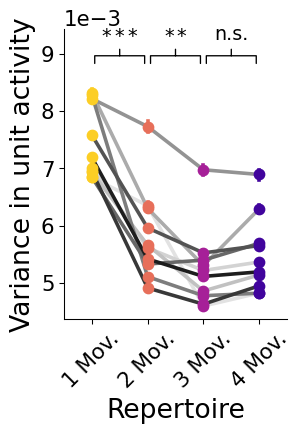

In [8]:
# variance in unit activity
g = dt.compare_measure(measures_df, 'var_rates', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in unit activity')))

plt.savefig(SUBFIG_DIR+ '/var_rates_all.pdf', format = 'pdf', bbox_inches = 'tight')


0.0009765625
0.001953125
0.9990234375
0.919921875
0.615234375
0.9931640625


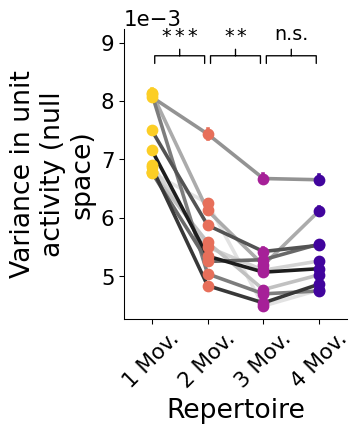

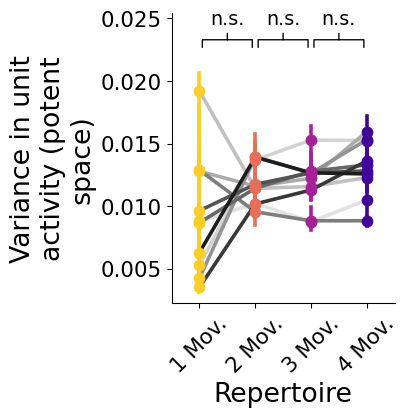

In [4]:
# variance in unit activity
g= dt.compare_measure(measures_df, 'var_rates_null', reps, stats_alternative = 'greater', ci = ci)
g.set_ylabel("\n".join(wrap('Variance in unit activity (null space)',20)))
plt.savefig(SUBFIG_DIR + 'var_unit_nullspace.pdf', format = 'pdf', bbox_inches = 'tight')

g= dt.compare_measure(measures_df, 'var_rates_potent', reps, stats_alternative = 'greater', ci = ci)
g.set_ylabel("\n".join(wrap('Variance in unit activity (potent space)',20)))
plt.savefig(SUBFIG_DIR + 'var_unit_potentspace.pdf', format = 'pdf', bbox_inches = 'tight')


0.0244140625
0.4609375
0.8623046875


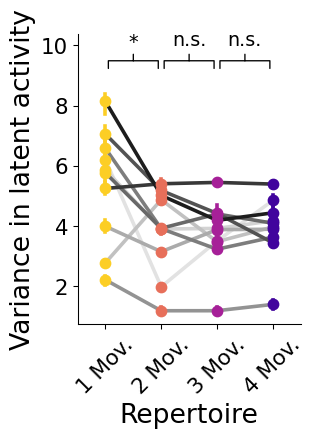

In [10]:
# variance in latent activity
g = dt.compare_measure(measures_df, 'var_pca', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in latent activity')))
plt.savefig(SUBFIG_DIR+ '/var_pca_all.pdf', format = 'pdf', bbox_inches = 'tight')


0.0009765625
0.0068359375
0.001953125


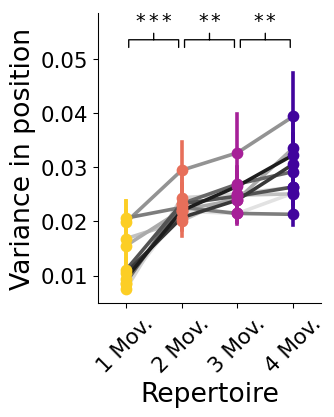

In [11]:
# variance in position
g = dt.compare_measure(measures_df, 'var_pos', reps, stats_alternative = 'less')
g.set_ylabel("\n".join(wrap('Variance in position')))

plt.savefig(SUBFIG_DIR+ '/var_position_all.pdf', format = 'pdf', bbox_inches = 'tight')


#### X Velocity

0.0009765625
0.0654296875
0.9033203125


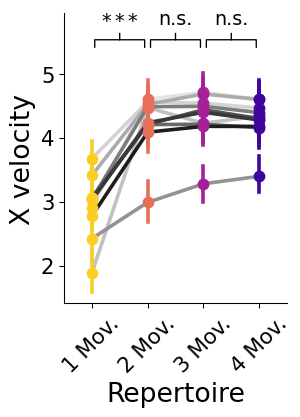

In [12]:
# x velocity
g = dt.compare_measure(measures_df, 'xvels', reps, stats_alternative = 'less')
g.set_ylabel("\n".join(wrap('X velocity',15)))

plt.savefig(SUBFIG_DIR+ '/x_velocity_all.pdf', format = 'pdf', bbox_inches = 'tight')


#### Adding noise

In [13]:
redo = True
datafile = 'uni_10.0_rad'
fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'mse_with_noise.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        mse_df = pickle.load(f)
else:
    rows_list = []
    for noise in tqdm([0.0,0.2,0.4,0.6,0.8,1.0]):
        for seed in seeds:
            for repertoire in repertoires:

                mse = dt.get_testing_MSE(seed,sim_set, repertoire, noise=noise, datafile = datafile)

                dict_temp = {'seed':seed,
                            'repertoire':repertoire,                                           
                            'mse': mse,
                            'noise': noise,
                    }
                rows_list.append(dict_temp)

    mse_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(mse_df,f)

  0%|          | 0/6 [00:00<?, ?it/s]

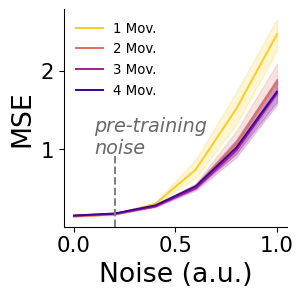

In [14]:
moveset = dt.get_moveset(repertoires[0])
abr_dict = Constants.REPERTOIRE_ABR_DICTS[moveset]
 
plt.figure(figsize=(3,3))
colors = [cm.get_cmap('plasma_r')(i) for i in np.linspace(0.1,0.9,4)]
colors = colors[:len(reps)]
g=sns.lineplot(data = mse_df[(mse_df.repertoire.isin(repertoires))], x = 'noise', y ='mse', hue='repertoire', palette = colors)
g.set_xlabel('Noise (a.u.)')
g.set_ylabel('MSE')
g.axvline(0.2, 0, 0.34, color = 'grey', linestyle='dashed')
plt.text(0.1, 0.95, "pre-training \nnoise", horizontalalignment='left', size='x-large', color='dimgrey', fontstyle ='italic')

plt.legend(labels=[abr_dict[s] for s in reps],frameon=False)
plt.savefig(SUBFIG_DIR+ '/mse_with_noise_all.pdf', format = 'pdf', bbox_inches = 'tight')


In [15]:
from matplotlib.collections import LineCollection

def get_interval(X, cues, rel_start, rel_end):
    interval = np.zeros((X.shape[0], rel_end - rel_start + 1, X.shape[2]))
    for trial in range(X.shape[0]):
        cue = cues[trial]
        interval[trial] = X[trial, (cue + rel_start):(cue + rel_end +1),]
    return interval

def plot_noise(sim_set1, sim_set2, repertoire1, repertoire2, 
    noise = None, datafile = 'uni_10.0', ntrials = None, rep_trial = None, 
    rel_start = int(Constants.WINDOW_exec[0]/Constants.BIN_SIZE), 
    rel_end = int(Constants.WINDOW_exec[1]/Constants.BIN_SIZE)):

    fig, axs = plt.subplots(ncols = 2)
    colors = [cm.get_cmap('viridis')(i) for i in np.linspace(0.1,0.9,4)]

    #FIRST SET
    sim_setdata1 = Constants.SIM_SET_DATA[sim_set1]
    outdir = dt.get_outdir(seed, sim_set1, repertoire1)

    #get original target_params (all tasks)
    test_data_orig = dt.get_test_data(sim_setdata1,repertoire1,seed)
    target_param1 = test_data_orig['target_param']
    colors1 = dt.get_colormap(target_param1,cmap = ('viridis' if (len(np.unique(target_param1)) == 1) else 'viridis_r'))

    #get original output (all tasks), output without noise (single task), output with noise
    _, _, output1_orig, _ = test_model(outdir, noise = 0.2)
    _, _, output1, _ = test_model(outdir, noise = 0.2, datafile = datafile+sim_setdata1)
    _, _, output1_noise, _ = test_model(outdir, noise = noise, datafile = datafile+sim_setdata1)
    test_data = dt.get_test_data(sim_setdata1, datafile, seed)
    
    output1_orig = get_interval(output1_orig, test_data_orig['go_onset'], rel_start, rel_end)
    output1 = get_interval(output1, test_data['go_onset'], rel_start, rel_end)
    output1_noise = get_interval(output1_noise, test_data['go_onset'], rel_start, rel_end)

    #SECOND SET
    sim_setdata2 = Constants.SIM_SET_DATA[sim_set2]
    outdir = dt.get_outdir(seed, sim_set2, repertoire2)
    
    #get original target_params (all tasks)
    test_data_orig = dt.get_test_data(sim_setdata2,repertoire2,seed)
    target_param2 = test_data_orig['target_param']
    colors2 = dt.get_colormap(target_param2,cmap = ('viridis' if (len(np.unique(target_param2)) == 1) else 'viridis_r'))
    
    #get original output (all tasks), output without noise (single task), output with noise
    _, _, output2_orig, _ = test_model(outdir,  noise = 0.2)
    _, _, output2, _ = test_model(outdir, noise = 0.2, datafile = datafile+sim_setdata2)
    _, _, output2_noise, _ = test_model(outdir, noise = noise, datafile = datafile+sim_setdata2)
    test_data = dt.get_test_data(sim_setdata2, datafile, seed)
    output2_orig = get_interval(output2_orig, test_data_orig['go_onset'], rel_start, rel_end)
    output2 = get_interval(output2, test_data['go_onset'], rel_start, rel_end)
    output2_noise = get_interval(output2_noise, test_data['go_onset'], rel_start, rel_end)
    
    #PLOTTING
    axs[0].clear()
    axs[1].clear()
    trials = ntrials if ntrials is not None else output1.shape[0]
    rep_trial = rep_trial or 20

    #plot first output with noise
    for i in range(trials): 
        axs[0].plot(output1_noise[i,:,0],output1_noise[i,:,1],alpha = 0.3, color = 'lightgrey') 
    #plot first output
    for i in range(trials):
        axs[0].plot(output1_orig[i,:,0],output1_orig[i,:,1],alpha = 0.2, color = colors1[target_param1[i]]) 
        axs[0].plot(output1[i,:,0],output1[i,:,1], alpha = 0.2, color = colors[0])
    #plot single example of output with noise
    points = np.expand_dims(output1_noise[rep_trial,:,:],1)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,points.shape[0])
    lc = LineCollection(segments, cmap='spring')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs[0].add_collection(lc)
    plt.setp(line, zorder=20)
    # axs[0].plot(output1_noise[rep_trial,:,0],output1_noise[rep_trial,:,1],alpha = 0.8, color = 'hotpink')
    axs[0].set_xlim([-10,10])
    axs[0].set_ylim([-10,10])
    axs[0].set_aspect(1)

    #plot second output with noise
    for i in range(trials): 
        axs[1].plot(output2_noise[i,:,0],output2_noise[i,:,1],alpha = 0.3, color = 'lightgrey')
    #plot second output
    for i in range(trials):
        axs[1].plot(output2_orig[i,:,0],output2_orig[i,:,1],alpha = 0.2, color = colors2[target_param2[i]]) 
        axs[1].plot(output2[i,:,0],output2[i,:,1], color = colors[0], alpha = 0.2) 
    #plot single example of output with noise
    points = np.expand_dims(output2_noise[rep_trial,:,:],1)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,points.shape[0])
    lc = LineCollection(segments, cmap='spring')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs[1].add_collection(lc)
    plt.setp(line, zorder=20)
    # axs[1].plot(output2_noise[rep_trial,:,0],output2_noise[rep_trial,:,1],alpha = 0.8, color = 'hotpink')
    axs[1].set_xlim([-10,10])
    axs[1].set_ylim([-10,10])
    axs[1].set_aspect(1)

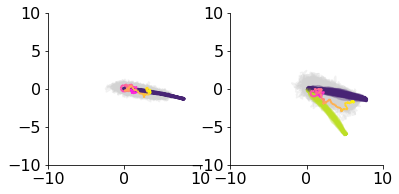

In [16]:
%matplotlib inline 
sim_set1 = 'uni_rad'
sim_set2 = 'uni_rad'
repertoire1= 'uni_10.0'
repertoire2= 'uni_2movs_10_50'
noise = 1.0
seed = Constants.SEED_EX #seeds[-1]

rep_trial = 15 
plot_noise(sim_set1, sim_set2, repertoire1, repertoire2, 
    noise = noise, datafile = 'uni_10.0', ntrials = None, rep_trial = rep_trial)
plt.savefig(SUBFIG_DIR + 'output_noise.pdf', format = 'pdf', bbox_inches = 'tight')


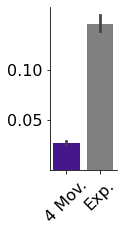

In [17]:
monkey_data = np.load(Constants.PROJ_DIR + 'data/dataset_centerout.npy', allow_pickle=True).item()
monkey_pos = monkey_data['target']
targets = np.unique(monkey_data['target_id'])
rel_start = int(Constants.WINDOW_exec[0]/Constants.BIN_SIZE)
rel_end = int(Constants.WINDOW_exec[1]/Constants.BIN_SIZE)

monkey_var_pos = []
for target in targets:
    idx = np.where(monkey_data['target_id'] == target)[0]
    go_cues = monkey_data['go_onset'][idx]
    pos = get_interval(monkey_pos[idx], go_cues, rel_start, rel_end-1)
    monkey_var_pos.append(np.var(pos, axis = 0).flatten())
monkey_var_pos = np.array(monkey_var_pos).flatten()
monkey_df = pd.DataFrame({'var_pos':monkey_var_pos, 'repertoire':'monkey'})

df = measures_df[['seed','repertoire','var_pos']]  
df = df[df.repertoire == repertoires[-1]]      
df = df.explode('var_pos')
rnn_var_pos = df.var_pos.values

var_pos_df = pd.concat([df, monkey_df])


fig, ax = plt.subplots(figsize=(1.2,3))
#plot points
point_colors = [cm.get_cmap('plasma_r')(i) for i in np.linspace(0.1,0.9,4)][-1]
point_colors = [point_colors] + ['grey']
g = sns.barplot(x="repertoire", y='var_pos', data=var_pos_df, palette = point_colors, ax = ax, estimator=np.median)
g.set_xticklabels(['4 Mov.', 'Exp.'])
g.set_yticks([0.05,0.10])
g.set_ylabel('')
g.set_xlabel('')
plt.xticks(rotation=45)
plt.savefig(SUBFIG_DIR  + '/var_position_exp.pdf', format = 'pdf', bbox_inches = 'tight')

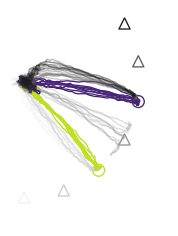

In [5]:
fig, ax = plt.subplots()
seed = Constants.SEED_EX
r = '10_50'
start, end = [-int(x) for x in r.split('_')]
rep = f'uni_2movs_{r}'
outdir = dt.get_outdir(seed, 'uni_rad', rep)
datadir,_,output,_ = test_model(outdir, datafile = 'uni_7movs_-30_90_rad')

# get data
datname = Constants.PROJ_DIR + datadir
data = np.load(datname+'.npy',allow_pickle = True).item()['test_set1']    
task_info = np.array(data['target_param'])
task_info = [(x - 2*math.pi) if x > math.pi else x for x in task_info]
task_info = np.rint(np.degrees(task_info))

#plotting
np.random.seed(1234) #choose random trials to plot

targets = np.unique(task_info)
known = [start, end]
unknown = [x for x in targets if x not in known]

rep_cmap = dt.get_colormap(known,Constants.MOVEMENT_CMAP+'_r')
nonrep_cmap = dt.get_colormap(unknown,'Greys')

for target in np.unique(task_info):
    target_idx = np.random.choice(np.where(task_info == target)[0], 10)
    output_ = output[target_idx]

    # graph trajectory positions
    isknown = target in known
    colormap = rep_cmap if isknown else nonrep_cmap

    for j in range(output_.shape[0]):
        ax.plot(output_[j,:,0],output_[j,:,1], '.', c = colormap[target],
                linestyle = '-', linewidth = 1, marker = None, alpha = 1.0 if isknown else 0.3)
    angle = math.radians(target)
    ax.scatter(8*math.cos(angle), 8*math.sin(angle), 
            facecolors = 'none', edgecolors = colormap[target], 
            s = 80 if isknown else 70, marker = 'o' if isknown else '^', linewidths = 1, alpha = 1.0 if isknown else 1)

ax.set_aspect(1)
ax.set_xlim([-1,10])
ax.set_ylim([-10,5])
ax.set_axis_off()

plt.savefig(SUBFIG_DIR+ f'generalization_output_{seed}.pdf', format='pdf')